<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 1: BERT Classification Model</p>
</div>

In [ ]:
!nvidia-smi

Sun Jun  6 00:23:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.5.0


In [ ]:
!pip install -q tensorflow==2.3.0

     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 20.1MB 162kB/s 
     |████████████████████████████████| 2.9MB 50.2MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1382 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 29.49 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 7.3MB 10.6MB/s 
     |████████████████████████████████| 194kB 56.8MB/s 
     |████████████████████████████████| 15.3MB 204kB/s 
     |████████████████████████████████| 9.9MB 40.2MB/s 
     |████████████████████████████████| 296kB 51.1MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 27.4MB 112kB/s 
     |████████████████████████████████| 174kB 59.9MB/s 
     |████████████████████████████████| 3.9MB 45.2MB/s 
     |████████████████████████████████| 686kB 44.3MB/s 
     |████████████████████████████████| 358kB 57.2MB/s 
     |████████████████████████████████| 1.2MB 22.3MB/s 
     |████████████████████████████████| 10.3MB 44.2MB/s 
     |████████████████████████████████| 38.2MB 1.2MB/s 
     |████████████████████████████████| 645kB 44.7MB/s 
     |████████████████████████████████| 3.0MB 27.3MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 81kB 12.3

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)

## Task 1: Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df= pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',compression='zip',low_memory=False)


In [ ]:
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<AxesSubplot:title={'center':'Target distribution'}, ylabel='Frequency'>

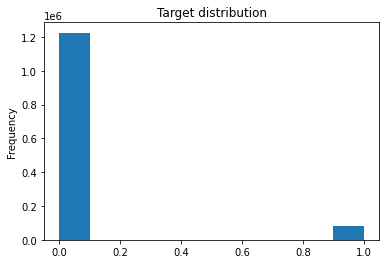

In [ ]:
df.target.plot(kind='hist', title='Target distribution')

## Task 2: Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df.shape, valid_df.shape

((9795, 3), (972, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data=tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data=tf.data.Dataset.from_tensor_slices((valid_df.question_text.values, valid_df.target.values))

  for text,label in train_data.take(1):
    print(text)
    print(label)
  

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 3: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""
label_list=[0,1]
max_seq_length=120
train_batch_size=32
# Label categories
# maximum length of (token) input sequences
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer= tokenization.FullTokenizer(vocab_file,do_lower_case)

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2



In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 4: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [ ]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a=text.numpy(),
                                             text_b=None,
                                             label=label.numpy())
  feature = classifier_data_lib.convert_single_example(0,example,label_list,max_seq_length,tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 5: Wrap a Python Function into a TensorFlow op for Eager Execution

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id=tf.py_function(to_feature, inp=[text,label],
                                                          Tout=[tf.int32,tf.int32,tf.int32,tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = { 
      'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids' : segment_ids    
  }

  return (x, label_id)

  

## Task 6: Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder= True)
  .prefetch(tf.data.experimental.AUTOTUNE))
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [ ]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(32, 120), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 7: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [ ]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,
                                         name = 'input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,
                                         name = 'input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,),dtype=tf.int32,
                                         name = 'input_type_ids')
  
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1,activation='sigmoid', name = 'output')(drop)
  model= tf.keras.Model(
      inputs={      
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids' : input_type_ids
       },
      outputs= output)
  return model


## Task 8: Fine-Tune BERT for Text Classification

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

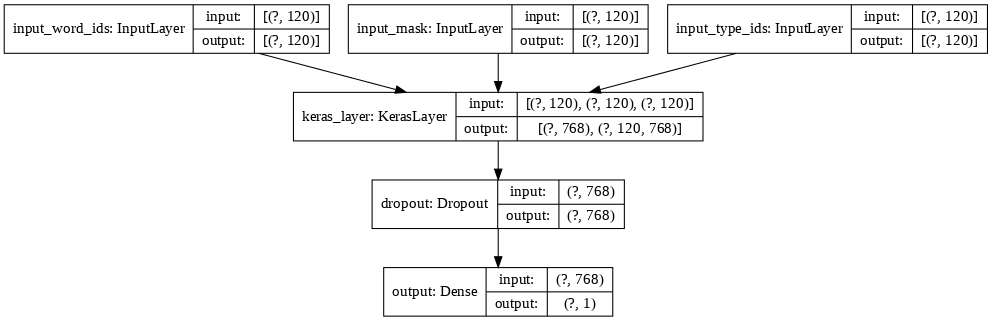

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

In [ ]:
# Train model
epochs=4
history= model.fit(train_data,
                   validation_data=valid_data,
                   epochs=epochs,
                   verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.0094 - binary_accuracy: 0.9965WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_test_batch_end` time: 0.2574s). Check your callbacks.


306/306 [==============================] - 253s 826ms/step - loss: 0.0094 - binary_accuracy: 0.9965 - val_loss: 0.2604 - val_binary_accuracy: 0.9375
Epoch 2/4
306/306 [==============================] - 253s 826ms/step - loss: 0.0148 - binary_accuracy: 0.9950 - val_loss: 0.2644 - val_binary_accuracy: 0.9510
Epoch 3/4
306/306 [==============================] - 253s 826ms/step - loss: 0.0070 - binary_accuracy: 0.9974 - val_loss: 0.3161 - val_binary_accuracy: 0.9531
Epoch 4/4
306/306 [==============================] - 252s 825ms/step - loss: 0.0062 - binary_accuracy: 0.9982 - val_loss: 0.2802 - val_binary_accuracy: 0.9573


## Task 9: Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

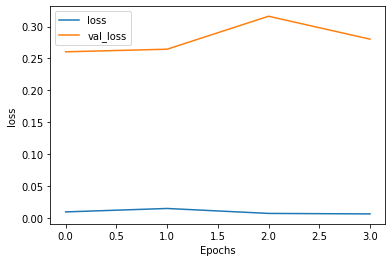

In [ ]:
plot_graphs(history,'loss')

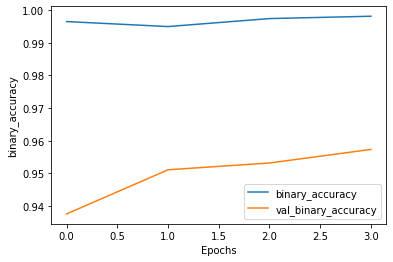

In [ ]:
plot_graphs(history,'binary_accuracy')

In [ ]:
sample_example=['Are you ashamed of being an Indian?'
,'which is the best company to work for?'
,'why are you a opportunist?'
,'I want to be a Datascientist, what are skills I need to build?']
test_data=tf.data.Dataset.from_tensor_slices((sample_example,[0]*len(sample_example)))
test_data=(test_data.map(to_feature_map).batch(1))
preds=model.predict(test_data)
threshold= 0.01
['Insincere' if pred>=threshold else 'Sincere' for pred in preds]
#between 0 and 1

['Insincere', 'Sincere', 'Insincere', 'Sincere']